<a href="https://colab.research.google.com/github/1kaiser/ICESAT2/blob/main/GraphConnectionICESAT2Photon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# prerequisite

In [ ]:
list_A = ['https://n5eil02u.ecs.nsidc.org/esir/5000004058045/239104701/processed_ATL03_20211108045334_07141302_005_01.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000004058045/226925046/processed_ATL03_20210627231818_00661206_005_01.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000004058045/226819567/processed_ATL03_20210530004215_10111106_005_01.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000004058045/226455818/processed_ATL03_20210208175352_07141002_005_01.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000004058045/225517656/processed_ATL03_20200211111433_07140602_005_01.h5',
 'https://n5eil02u.ecs.nsidc.org/esir/5000004056727/223502286/processed_ATL03_20190126172441_04470206_005_01.h5']

for i in list_A:
  !wget --http-user=kroy0001 --http-password=/#j%kWrPA,8.HRe {i}


In [ ]:
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/ASTER_DEM.tif #getting the dem
!wget https://github.com/1kaiser/ICESAT2/releases/download/1/landsat2.zip
!unzip '*.zip'
!rm -r *.zip

# stage 1

In [ ]:
#@title **Elevation & Distance Sample Extraction** { vertical-output: true }
filename = "/content/processed_ATL03_20200211111433_07140602_005_01.h5" #@param {type:"string"}
track_name = "gt2r" #@param {type:"string"}
start_point = 20000 #@param {type:"integer"}
distance_range = 1500 #@param {type:"integer"}
elevation_band_thickness = 150 #@param {type:"integer"}


import h5py
import numpy as np
import matplotlib.pyplot as plt

def create_geometric_graph(elevations, distances, elevation_weight, distance_weight):
    # Create a complete graph with nodes representing the given points
    num_points = len(elevations)
    edges = [(i, j) for i in range(num_points) for j in range(i+1, num_points)]
    
    # Compute the weights of the edges between all pairs of nodes
    weights = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i+1, num_points):
            elevation_diff = abs(elevations[i] - elevations[j])
            weights[i][j] = elevation_weight * elevation_diff + distance_weight * abs(distances[i] - distances[j])
            weights[j][i] = weights[i][j]
    
    # Create a GeometricGraph object from the edge list and weights
    geom_graph = (edges, weights)
    
    return geom_graph

def extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness):
    # Open the HDF5 file and extract data
    f = h5py.File(filename, 'r')
    h_ph_data = f['/'+str(track_name)+'/heights/h_ph']
    lat_ph_data = f['/'+str(track_name)+'/heights/lat_ph']
    lon_ph_data = f['/'+str(track_name)+'/heights/lon_ph']

    # Calculate distance along track using haversine formula
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Earth radius in km
        dLat = np.radians(lat2 - lat1)
        dLon = np.radians(lon2 - lon1)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
        c = 2*np.arcsin(np.sqrt(a))
        return R*c*1000.0

    dist_ph_along_data = [haversine(lat_ph_data[0], lon_ph_data[0], lat_ph_data[i], lon_ph_data[i]) for i in range(len(lat_ph_data))]

    # Select data based on a starting point, distance range, and elevation band thickness
    dist_ph_along_data = np.array(dist_ph_along_data)
    h_ph_data = np.array(h_ph_data)

    c = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range))[0]

    median_height = np.median(h_ph_data[c])
    d = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range) & 
                 (h_ph_data > median_height - elevation_band_thickness/2) &
                 (h_ph_data < median_height + elevation_band_thickness/2))[0]

    # Extract elevation and distance data
    elevation = h_ph_data[d]
    distance = dist_ph_along_data[d]

    return distance, elevation

# filename = '/content/processed_ATL03_20200211111433_07140602_005_01.h5'
# track_name = 'gt2r'
# start_point = 25500
# distance_range = 300
# elevation_band_thickness = 50

distance, elevation = extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness)


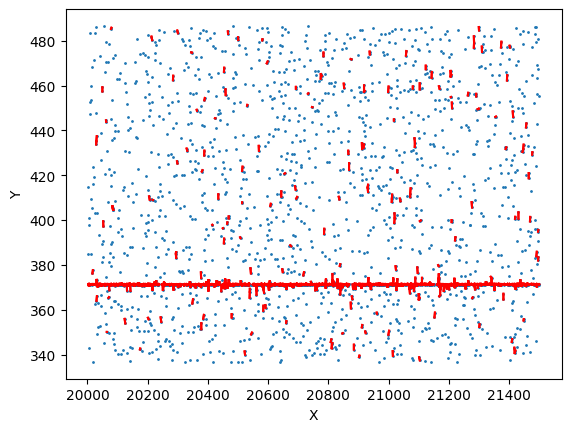

In [ ]:
import matplotlib.pyplot as plt



# Generate the elevation and distance values.
elevation = elevation
distance = distance


# Create a points array.
def create_points(elevation, distance):
  return jnp.array([
    [elevation[i], distance[i]]
    for i in range(len(elevation))
  ])


import numpy as np

def create_adjacency_matrix(points, threshold):
  distance_matrix = np.linalg.norm(points[:, None] - points, axis=2)
  mask = distance_matrix < threshold
  adjacency_matrix = np.where(mask, 1, 0)
  return adjacency_matrix


# Create the points array.
points = create_points(elevation, distance)
n = len(elevation)
adjacency_matrix = np.zeros((n, n))
adjacency_matrix = create_adjacency_matrix(points, 3)
# # Create an adjacency matrix.
# adjacency_matrix = np.zeros((n, n))
# for i in range(n):
#   for j in range(n):
#     if np.linalg.norm(points[i] - points[j]) < 3:
#       adjacency_matrix[i, j] = 1

# Plot the points and the connections.
plt.figure()
plt.scatter(points[:, 1], points[:, 0], s = 1)

for i in range(n):
  for j in range(n):
    if adjacency_matrix[i, j] == 1:
      plt.plot( [points[i, 1], points[j, 1]], [points[i, 0], points[j, 0]], 'r-')

plt.xlabel("X")
plt.ylabel("Y")
plt.show()


# test stage

In [ ]:
#@title test code
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


# Create a points array.
def create_points(elevation, distance):
  return jnp.array([
    [elevation[i], distance[i]]
    for i in range(len(elevation))
  ])

# Swap the axes of the points array.
def swap_axes(points):
  return points[:, ::-1]

# Create a distance matrix between the points.
def create_distance_matrix(points):
  return jnp.linalg.norm(points[:, None] - points, axis=2)

# Create a mask of the points that are within the threshold distance.
def create_mask(distance_matrix, threshold):
  return jnp.less_equal(distance_matrix, threshold)

# Create an adjacency matrix from the mask.
def create_adjacency_matrix(mask):
  return jnp.where(mask, 1, 0)

# Convert the adjacency matrix to a NumPy array of size 20x20.
def convert_adjacency_matrix_to_numpy(adjacency_matrix, n):
  return adjacency_matrix.reshape((n, n))






# Plot the points and the connections using the adjacency matrix.
def plot_points_and_connections(points, adjacency_matrix, xlabel, ylabel):
  plt.figure()
  plt.scatter(points[:, 1], points[:, 0], s = 1)
  for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix[0])):
      if adjacency_matrix[i][j] == 1:
        plt.plot([points[i, 1], points[j, 1]], [points[i, 0], points[j, 0]], 'r-')

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.show()

# Get the number of points from the user.
# n = int(input("Enter the number of points: "))
n = len(elevation)
# Generate the elevation and distance values.
elevation = elevation
distance = distance

# Create the points array.
points = create_points(elevation, distance)

# Create the distance matrix between the points.
distance_matrix = create_distance_matrix(points)

# Create a mask of the points that are within the threshold distance.
threshold = 3
mask = create_mask(distance_matrix, threshold)

# Create an adjacency matrix from the mask.
adjacency_matrix = create_adjacency_matrix(mask)

# Convert the adjacency matrix to a NumPy array of size 20x20.
adjacency_matrix_numpy = convert_adjacency_matrix_to_numpy(adjacency_matrix, n)

# Plot the points and the connections using the adjacency matrix.
plot_points_and_connections(points, adjacency_matrix_numpy, "Distance", "Elevation")


In [ ]:
!pip install rasterio

In [ ]:
#@title **Elevation & Distance Sample Extraction based on distance threshold in meters** { vertical-output: true }
fsize = 30
filename = "/content/processed_ATL03_20210208175352_07141002_005_01.h5" #@param {type:"string"}
track_name = "gt3r" #@param ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
start_point = 27500 #@param {type:"integer"}
distance_range = 1000 #@param {type:"integer"}
elevation_band_thickness = 500 #@param {type:"integer"}
min_height_zone = elevation_band_thickness

import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import jax.numpy as jnp

def create_geometric_graph(elevations, distances, elevation_weight, distance_weight):
    # Create a complete graph with nodes representing the given points
    num_points = len(elevations)
    edges = [(i, j) for i in range(num_points) for j in range(i+1, num_points)]
    
    # Compute the weights of the edges between all pairs of nodes
    weights = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i+1, num_points):
            elevation_diff = abs(elevations[i] - elevations[j])
            weights[i][j] = elevation_weight * elevation_diff + distance_weight * abs(distances[i] - distances[j])
            weights[j][i] = weights[i][j]
    
    # Create a GeometricGraph object from the edge list and weights
    geom_graph = (edges, weights)
    
    return geom_graph

# Calculate distance along track using haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
    c = 2*np.arcsin(np.sqrt(a))
    return R*c*1000.0


w_x = 1
h_y = 1
fig, ax = plt.subplots(figsize=(30,6), dpi = 200)


def extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness):
    # Open the HDF5 file and extract data
    f = h5py.File(filename, 'r')
    h_ph_data = f['/'+str(track_name)+'/heights/h_ph']
    lat_ph_data = f['/'+str(track_name)+'/heights/lat_ph']
    lon_ph_data = f['/'+str(track_name)+'/heights/lon_ph']



    dist_ph_along_data = [haversine(lat_ph_data[0], lon_ph_data[0], lat_ph_data[i], lon_ph_data[i]) for i in range(len(lat_ph_data))]

    # Select data based on a starting point, distance range, and elevation band thickness
    dist_ph_along_data = np.array(dist_ph_along_data)
    h_ph_data = np.array(h_ph_data)

        # Plot the dataset
    ax.scatter(dist_ph_along_data, h_ph_data, s=1, c = 'y')
    ax.set_xlabel('Along-Track Distance(m)', fontsize = fsize)
    ax.set_ylabel('height of photons',fontsize = fsize)
    ax.set_title('h_ph dataset from gt1l/heights',fontsize = int(fsize * 1.2 ))
    ax.set_ylim(np.median(h_ph_data) - 1500, np.median(h_ph_data) + 1500)

    
    c = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range))[0]

    median_height = np.median(h_ph_data[c])
    d = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range) & 
                 (h_ph_data > median_height - elevation_band_thickness/2) &
                 (h_ph_data < median_height + elevation_band_thickness/2))[0]

    # Extract elevation and distance data
    elevation = h_ph_data[d]
    distance = dist_ph_along_data[d]

        
    ax.grid(True)
    ax.scatter(np.array(dist_ph_along_data)[d], np.array(h_ph_data)[d], s=2, c = 'g')
    x_mean = np.mean(np.array(dist_ph_along_data)[d])
    y_mean = np.median(np.array(h_ph_data)[d])
    ax.scatter(x_mean, y_mean, s= 40)
    ax.tick_params(axis='both', which='major', labelsize=int(fsize * 0.7))



    rect = patches.Rectangle((x_mean-distance_range/2, y_mean-min_height_zone/2), distance_range, min_height_zone, fill=False, linestyle='dotted', linewidth=2, edgecolor='red')
    ax.add_patch(rect)
    fig.gca().set_aspect('equal')

    ax2 = fig.add_axes([0.5 - w_x / 2 , -0.8 - h_y/2 , w_x, h_y])
    ax2.set_xlabel('Along-Track Distance(m)', fontsize = fsize)
    ax2.set_ylabel('photon height',fontsize = fsize)
    ax2.set_ylim(y_mean-min_height_zone/2 - 10, y_mean+min_height_zone/2 + 10)
    ax2.set_title('Zoomed-in view of h_ph dataset\nfrom gt1l/heights',fontsize = int(fsize * 1.2 ))
    ax2.tick_params(axis='both', which='major', labelsize=int(fsize * 0.7))
    ax2.grid(True)
    ax2.scatter(np.array(dist_ph_along_data)[d], np.array(h_ph_data)[d], s=20, alpha= 0.4)
    fig.gca().set_aspect('equal')

    from osgeo import gdal

    raster_location = '/content/landsat2/HLSL30.020_B04_doy2019109_aid0001_43N.tif'
    # Load the second raster image into a numpy array using gdal
    crop_ds = gdal.Open(raster_location)
    crop_band = crop_ds.GetRasterBand(1)
    crop_data = crop_band.ReadAsArray()

    # Get the mask of the second band
    crop_mask = crop_band.GetMaskBand().ReadAsArray()

    # Create a masked array from the crop data and mask
    crop_masked = np.ma.masked_where(crop_mask == 0, crop_data)

    # Get the geotransform of the second raster
    crop_gt = crop_ds.GetGeoTransform()

    # Get the minimum and maximum x and y coordinates of the second raster
    crop_xmin = crop_gt[0]
    crop_xmax = crop_gt[0] + (crop_ds.RasterXSize * crop_gt[1])
    crop_ymin = crop_gt[3] + (crop_ds.RasterYSize * crop_gt[5])
    crop_ymax = crop_gt[3]

    import rasterio
    # Open the DEM raster file
    dem_in = rasterio.open('/content/ASTER_DEM.tif')
    dem_data = dem_in.read(1, masked=True)

    extent_data = rasterio.open(raster_location)
    extent = dem_in.window(extent_data.bounds.left,  extent_data.bounds.bottom, extent_data.bounds.right, extent_data.bounds.top)

    out_data = dem_in.read(1, window=extent, masked=True)



    ax3 = fig.add_axes([0.5 - w_x / 2 , -2.2 - h_y/2 , w_x, h_y])

    ax3.set_xlabel('Longitude', fontsize = fsize)
    ax3.set_ylabel('Latitude', fontsize = fsize)
    # ax3.set_ylim(y_mean - min_height_zone/2, y_mean + min_height_zone/2)
    ax3.set_title('Zoomed-in view of h_ph dataset\nfrom gt1l/heights',fontsize = int(fsize * 1.2 ))
    ax3.tick_params(axis='both', which='major', labelsize=int(fsize * 0.7))
    ax3.grid(True)

    ax3.imshow(out_data, extent=[crop_xmin, crop_xmax, crop_ymin, crop_ymax])

    ax3.scatter(lon_ph_data, lat_ph_data, s=1, alpha= 0.4, c ='g')
    ax3.scatter(np.array(lon_ph_data)[d], np.array(lat_ph_data)[d], s=20, alpha= 0.4, c = 'r')
    fig.gca().set_aspect('equal')


    return distance, elevation

# filename = '/content/processed_ATL03_20200211111433_07140602_005_01.h5'
# track_name = 'gt2r'
# start_point = 25500
# distance_range = 300
# elevation_band_thickness = 50

# Create a points array.
def create_points(elevation, distance):
  return jnp.array([
    [elevation[i], distance[i]]
    for i in range(len(elevation))
  ])


def create_adjacency_matrix(points, threshold):
  distance_matrix = np.linalg.norm(points[:, None] - points, axis=2)
  mask = distance_matrix < threshold
  adjacency_matrix = np.where(mask, 1, 0)
  return adjacency_matrix

def plot_points_and_connections(elevation, distance, threshold):
  # Create the points array.
  points = create_points(elevation, distance)
  n = len(elevation)
  adjacency_matrix = np.zeros((n, n))
  adjacency_matrix = create_adjacency_matrix(points, threshold)

  # Plot the points and the connections.
  ax4 = fig.add_axes([0.5 - w_x / 2 , -3.6 - h_y/2 , w_x, h_y])
  # fig = plt.figure(figsize=(12, 4), dpi=200)
  ax4.set_title('Nearest Neighbour connection view',fontsize = int(fsize * 1.2 ))

  for i in range(n):
    for j in range(n):
      if adjacency_matrix[i, j] == 1:
        ax4.plot( [points[i, 1], points[j, 1]], [points[i, 0], points[j, 0]], 'r-')
  ax4.scatter(points[:, 1], points[:, 0], s = 1)
  fig.gca().set_aspect('equal')
  ax4.tick_params(axis='both', which='major', labelsize=int(fsize * 0.7))
  ax4.grid(True)
  ax4.set_xlabel('distance', fontsize = fsize)
  ax4.set_ylabel('elevation', fontsize = fsize)
  # return fig

distance, elevation = extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness)
threshold = 3 #@param {type:"integer"}
plot_points_and_connections(elevation, distance, threshold)
# plt.show()

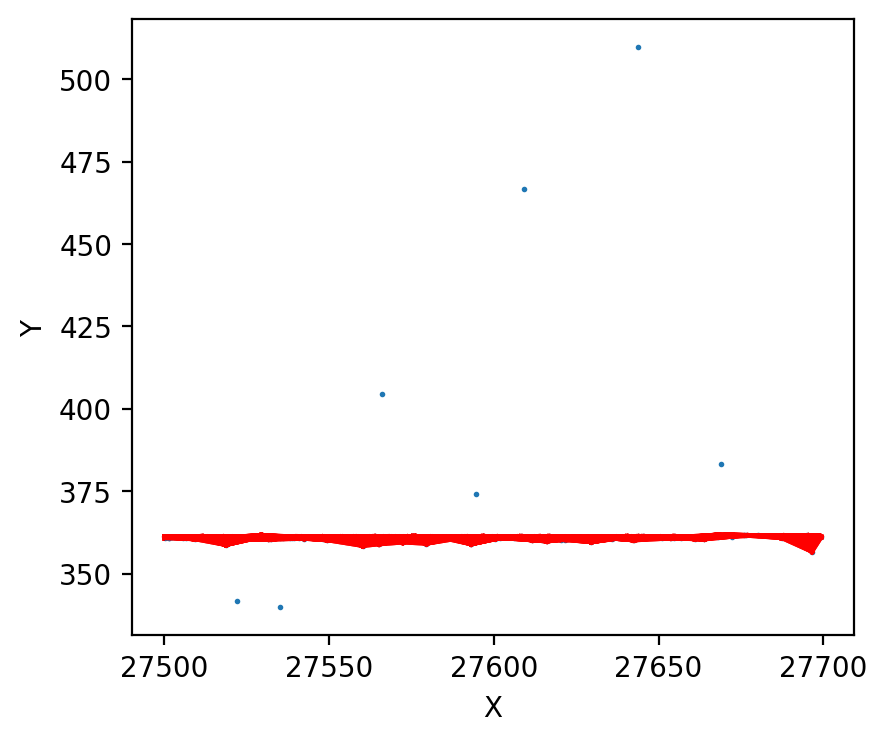

In [6]:
#@title **Elevation & Distance Sample Extraction based on DENSITY and MEDIAN threshold** { vertical-output: true }
filename = "/content/processed_ATL03_20210208175352_07141002_005_01.h5" #@param {type:"string"}
track_name = "gt2r" #@param ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]
start_point = 27500 #@param {type:"integer"}
distance_range = 200 #@param {type:"integer"}
elevation_band_thickness = 300 #@param {type:"integer"}


import h5py
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def create_geometric_graph(elevations, distances, elevation_weight, distance_weight):
    # Create a complete graph with nodes representing the given points
    num_points = len(elevations)
    edges = [(i, j) for i in range(num_points) for j in range(i+1, num_points)]
    
    # Compute the weights of the edges between all pairs of nodes
    weights = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(i+1, num_points):
            elevation_diff = abs(elevations[i] - elevations[j])
            weights[i][j] = elevation_weight * elevation_diff + distance_weight * abs(distances[i] - distances[j])
            weights[j][i] = weights[i][j]
    
    # Create a GeometricGraph object from the edge list and weights
    geom_graph = (edges, weights)
    
    return geom_graph

def extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness):
    # Open the HDF5 file and extract data
    f = h5py.File(filename, 'r')
    h_ph_data = f['/'+str(track_name)+'/heights/h_ph']
    lat_ph_data = f['/'+str(track_name)+'/heights/lat_ph']
    lon_ph_data = f['/'+str(track_name)+'/heights/lon_ph']

    # Calculate distance along track using haversine formula
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Earth radius in km
        dLat = np.radians(lat2 - lat1)
        dLon = np.radians(lon2 - lon1)
        lat1 = np.radians(lat1)
        lat2 = np.radians(lat2)
        a = np.sin(dLat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dLon/2)**2
        c = 2*np.arcsin(np.sqrt(a))
        return R*c*1000.0

    dist_ph_along_data = [haversine(lat_ph_data[0], lon_ph_data[0], lat_ph_data[i], lon_ph_data[i]) for i in range(len(lat_ph_data))]

    # Select data based on a starting point, distance range, and elevation band thickness
    dist_ph_along_data = np.array(dist_ph_along_data)
    h_ph_data = np.array(h_ph_data)

    c = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range))[0]

    median_height = np.median(h_ph_data[c])
    d = np.where((dist_ph_along_data > start_point) & (dist_ph_along_data < start_point + distance_range) & 
                 (h_ph_data > median_height - elevation_band_thickness/2) &
                 (h_ph_data < median_height + elevation_band_thickness/2))[0]

    # Extract elevation and distance data
    elevation = h_ph_data[d]
    distance = dist_ph_along_data[d]

    return distance, elevation

# filename = '/content/processed_ATL03_20200211111433_07140602_005_01.h5'
# track_name = 'gt2r'
# start_point = 25500
# distance_range = 300
# elevation_band_thickness = 50

# Create a points array.
def create_points(elevation, distance):
  return jnp.array([
    [elevation[i], distance[i]]
    for i in range(len(elevation))
  ])


def create_adjacency_matrix(points, threshold_type):
  """Creates an adjacency matrix from a set of points.

  Args:
    points: A NumPy array of points.
    threshold_type: A string that specifies the type of threshold to use.
    The possible values are:
      - "density": The threshold will be based on the density of the points.
      - "median": The threshold will be based on the median distance between all pairs of points.

  Returns:
    An adjacency matrix.
  """

  if threshold_type == "density":
    threshold = np.sqrt(len(points) / np.pi)
  elif threshold_type == "median":
    threshold = np.median(np.linalg.norm(points[:, None] - points, axis=2))
  else:
    raise ValueError("Invalid threshold type: {}".format(threshold_type))
  distance_matrix = np.linalg.norm(points[:, None] - points, axis=2)
  mask = distance_matrix < threshold
  adjacency_matrix = np.where(mask, 1, 0)
  return adjacency_matrix



# def create_adjacency_matrix(points, threshold):
#   distance_matrix = np.linalg.norm(points[:, None] - points, axis=2)
#   mask = distance_matrix < threshold
#   adjacency_matrix = np.where(mask, 1, 0)
#   return adjacency_matrix

def plot_points_and_connections(elevation, distance, threshold):
  # Create the points array.
  points = create_points(elevation, distance)
  n = len(elevation)
  adjacency_matrix = np.zeros((n, n))
  adjacency_matrix = create_adjacency_matrix(points, "density")

  # Plot the points and the connections.
  fig = plt.figure(figsize=(12, 4), dpi=200)

  for i in range(n):
    for j in range(n):
      if adjacency_matrix[i, j] == 1:
        plt.plot( [points[i, 1], points[j, 1]], [points[i, 0], points[j, 0]], 'r-')
  plt.scatter(points[:, 1], points[:, 0], s = 1)
  plt.gca().set_aspect('equal')
  plt.xlabel("X")
  plt.ylabel("Y")
  return fig

distance, elevation = extract_elevation_data(filename, track_name, start_point, distance_range, elevation_band_thickness)
threshold = "density" #@param ["density", "median"]

plot_points_and_connections(elevation, distance, threshold)
plt.show()